<a href="https://colab.research.google.com/github/duendemza/machine_learning/blob/ataque_adv/ataque_adversario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

La idea de este notebook es generar un código que nos permite hacer fallar la red neuronal inception_v3 que lo que hace es clasificar imágenes.


In [0]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [0]:
# Keras nos proporciona el modelo pre entrenado por lo cual importamos el modelo
from keras.applications.inception_v3 import (
    InceptionV3,
    decode_predictions
)
from keras import backend as K

In [0]:
iv3 = InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [0]:
print(iv3.summary())  # Nos muestra la topologia de capas del modelo inception_v3: clasificador de imágenes.

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:
from keras.preprocessing import image

In [0]:
X = image.img_to_array(image.load_img("/content/drive/My Drive/data/gato.jpg", target_size=(299, 299)))
X = X.reshape([1, X.shape[0], X.shape[1], X.shape[2]]) # Acomodamos a lo que el modelo nos pide.
print(X.shape) # (tam_lote, )

(1, 299, 299, 3)


In [0]:
# Debemos cambiar el rango de nitidez que normalmente va de 0 a 255, para que vaya de -1 a 1
X /= 255
X -= 0.5
X *= 2

y = iv3.predict(X)  # resultado de haber metido la imágen que cargamos.

print(y.shape)  # esperamos un vector de tam 1000, cada clase de imagen con su probabilidad.

# decode_predictions nos ayuda a mapear esta probabilidad con una clase reconocible por humanos.
decode_predictions(y)

(1, 1000)
40960/35363 [==================================] - 0s 0us/step


[[('n02123159', 'tiger_cat', 0.33997178),
  ('n02124075', 'Egyptian_cat', 0.15163231),
  ('n02123045', 'tabby', 0.11312476),
  ('n03924679', 'photocopier', 0.022252422),
  ('n04553703', 'washbasin', 0.019436385)]]

**Ataque Adversario: **
Generar una imagen que ha sido manipulada para confudir la IA pero que al ojo humano es exactamente lo mismo. 
Vamos a cambiar los pixeles para que siga siendo la misma imagen pero con parámetros diferentes.

In [0]:
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

print(inp_layer, out_layer)

target_class = 951  # Esta clase es un limón
loss = out_layer[0, target_class]

grad = K.gradients(loss, inp_layer)[0]  # calculamos un gradiente entre el error y la variable de entrada
# Ahora tenemos qué valor debe variar nuestra imagen de entrada

# Keras nos permite definir una funcion de tipo caja negra
# en la que le decimos qué datos queremos ingresar y cuales queremos de salida
# para nuestro caso queremos ingresar la inp_layer y que nos genere el gradiente y el error.
# tenemos que además indicarle que tipo de prueva es, para nuestro caso la definimos como training.
optimize_gradiente = K.function([inp_layer, K.learning_phase()], [grad, loss])
adv = np.copy(X)

# Ponemos una cota entre lo que debe estar la manipulación de pixeles. La llamamos perturbacion
pert = 0.01
max_pert = X + 0.01
min_pert = X - 0.01

cost = 0.0

while cost < 0.95:
  gr, cost = optimize_gradiente([adv, 0]) # learning_phase = 0: training
  adv += gr
  adv = np.clip(adv, min_pert, max_pert) # acotamos los valores dentro de nuestras cotas
  adv = np.clip(adv, -1, 1)
print("lemon_cost", cost)

Tensor("input_1:0", shape=(None, 299, 299, 3), dtype=float32) Tensor("predictions/Softmax:0", shape=(None, 1000), dtype=float32)
lemon_cost 0.99379694


In [0]:
adv /= 2
adv += 0.5
adv *= 255

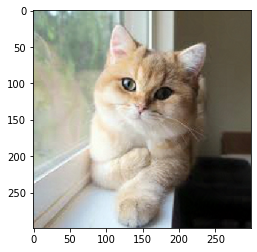

In [0]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [0]:
a = iv3.predict(adv)  # resultado de haber metido la imágen que cargamos.

print(a.shape)  # esperamos un vector de tam 1000, cada clase de imagen con su probabilidad.

# decode_predictions nos ayuda a mapear esta probabilidad con una clase reconocible por humanos.
decode_predictions(a)

(1, 1000)


[[('n01924916', 'flatworm', 1.0),
  ('n03950228', 'pitcher', 5.6137613e-28),
  ('n15075141', 'toilet_tissue', 0.0),
  ('n02319095', 'sea_urchin', 0.0),
  ('n02391049', 'zebra', 0.0)]]

Como vemos la imagen ya no la reconoce como un gato o algo similar, lo esta viendo como un gusano.

In [0]:
# vamos a guardar la imágen hackeada en nuestro drive
from PIL import Image
Im = Image.fromarray(adv[0].astype(np.uint8))
Im.save("/content/drive/My Drive/data/hacked.png")